In [1]:
# Import common libraries
import sys
import gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Create an environment
env = gym.make('Acrobot-v1')
env.reset(seed=505);

# Explore state (observation) space
print("State space")
print("- low:", env.observation_space.low)
print("- high:", env.observation_space.high)

# Explore action space
print("Action space:", env.action_space)

State space
- low: [ -1.        -1.        -1.        -1.       -12.566371 -28.274334]
- high: [ 1.        1.        1.        1.       12.566371 28.274334]
Action space: Discrete(3)


In [7]:
def create_tiling_grid(low, high, bins=(10, 10), offsets=(0.0, 0.0)):
    """Define a uniformly-spaced grid that can be used for tile-coding a space.
    Parameters
    ----------
    low : array_like
        Lower bounds for each dimension of the continuous space.
    high : array_like
        Upper bounds for each dimension of the continuous space.
    bins : tuple
        Number of bins or tiles along each corresponding dimension.
    offsets : tuple
        Split points for each dimension should be offset by these values.
    Returns
    -------
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    """
    grid = [np.linspace(low[dim], high[dim], bins[dim] + 1)[1:-1] + offsets[dim] for dim in range(len(bins))]
    return grid

def create_tilings(low, high, tiling_specs):
    """Define multiple tilings using the provided specifications.
    Parameters
    ----------
    low : array_like
        Lower bounds for each dimension of the continuous space.
    high : array_like
        Upper bounds for each dimension of the continuous space.
    tiling_specs : list of tuples
        A sequence of (bins, offsets) to be passed to create_tiling_grid().
    Returns
    -------
    tilings : list
        A list of tilings (grids), each produced by create_tiling_grid().
    """
    return [create_tiling_grid(low, high, bins, offsets) for bins, offsets in tiling_specs]

def discretize(sample, grid):
    """Discretize a sample as per given grid.
    Parameters
    ----------
    sample : array_like
        A single sample from the (original) continuous space.
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    Returns
    -------
    discretized_sample : array_like
        A sequence of integers with the same number of dimensions as sample.
    """
    return tuple(int(np.digitize(s, g)) for s, g in zip(sample, grid))  # apply along each dimension


def tile_encode(sample, tilings, flatten=False):
    """Encode given sample using tile-coding.
    Parameters
    ----------
    sample : array_like
        A single sample from the (original) continuous space.
    tilings : list
        A list of tilings (grids), each produced by create_tiling_grid().
    flatten : bool
        If true, flatten the resulting binary arrays into a single long vector.
    Returns
    -------
    encoded_sample : list or array_like
        A list of binary vectors, one for each tiling, or flattened into one.
    """
    encoded_sample = [discretize(sample, grid) for grid in tilings]
    return np.concatenate(encoded_sample) if flatten else encoded_sample

class QTable:
    """Simple Q-table."""
    def __init__(self, state_size, action_size):
        """Initialize Q-table.
        Parameters
        ----------
        state_size : tuple
            Number of discrete values along each dimension of state space.
        action_size : int
            Number of discrete actions in action space.
        """
        self.state_size = state_size
        self.action_size = action_size
        # Q-table, initialize all Q-values to zero
        # Note: If state_size = (9, 9), action_size = 2, q_table.shape should be (9, 9, 2)
        self.q_table = np.zeros(shape=(self.state_size + (self.action_size,)))

class TiledQTable:
    """Composite Q-table with an internal tile coding scheme."""
    
    def __init__(self, low, high, tiling_specs, action_size):
        """Create tilings and initialize internal Q-table(s).
        Parameters
        ----------
        low : array_like
            Lower bounds for each dimension of state space.
        high : array_like
            Upper bounds for each dimension of state space.
        tiling_specs : list of tuples
            A sequence of (bins, offsets) to be passed to create_tilings() along with low, high.
        action_size : int
            Number of discrete actions in action space.
        """
        self.tilings = create_tilings(low, high, tiling_specs)
        self.state_sizes = [tuple(len(splits)+1 for splits in tiling_grid) for tiling_grid in self.tilings]
        self.action_size = action_size
        self.q_tables = [QTable(state_size, self.action_size) for state_size in self.state_sizes]
    
    def get(self, state, action):
        """Get Q-value for given <state, action> pair.
        Parameters
        ----------
        state : array_like
            Vector representing the state in the original continuous space.
        action : int
            Index of desired action.
        Returns
        -------
        value : float
            Q-value of given <state, action> pair, averaged from all internal Q-tables.
        """
        # Encode state to get tile indices
        encoded_state = tile_encode(state, self.tilings)
        # Retrieve q-value for each tiling, and return their average
        value = 0.0
        for idx, q_table in zip(encoded_state, self.q_tables):
            value += q_table.q_table[tuple(idx + (action,))]
        value /= len(self.q_tables)
        return value
    
    def update(self, state, action, value, alpha=0.1):
        """Soft-update Q-value for given <state, action> pair to value.
        Instead of overwriting Q(state, action) with value, perform soft-update:
            Q(state, action) = alpha * value + (1.0 - alpha) * Q(state, action)
        Parameters
        ----------
        state : array_like
            Vector representing the state in the original continuous space.
        action : int
            Index of desired action.
        value : float
            Desired Q-value for <state, action> pair.
        alpha : float
            Update factor to perform soft-update, in [0.0, 1.0] range.
        """
        # Encode state to get tile indices
        encoded_state = tile_encode(state, self.tilings)
        # Update q-value for each tiling by update factor alpha
        for idx, q_table in zip(encoded_state, self.q_tables):
            value_ = q_table.q_table[tuple(idx + (action,))]  # current value
            q_table.q_table[tuple(idx + (action,))] = alpha * value + (1.0 - alpha) * value_

class SARSALearningAgent:
    """SARSA-Learning agent that can act on a continuous state space by discretizing it."""
    def __init__(self, env, tq, alpha=0.1, gamma=0.99,
                 epsilon=1.0, epsilon_decay_rate=0.9995, min_epsilon=.01, seed=0):
        """Initialize variables, create grid for discretization."""
        # Environment info
        self.env = env
        self.tq = tq 
        self.state_sizes = tq.state_sizes           # list of state sizes for each tiling
        self.action_size = self.env.action_space.n  # 1-dimensional discrete action space
        self.seed = np.random.seed(seed)
        print("Environment:", self.env)
        print("State space sizes:", self.state_sizes)
        print("Action space size:", self.action_size)
        # Learning parameters
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = self.initial_epsilon = epsilon  # initial exploration rate
        self.epsilon_decay_rate = epsilon_decay_rate   # how quickly should we decrease epsilon
        self.min_epsilon = min_epsilon

    def reset_episode(self, state):
        """Reset variables for a new episode."""
        # Gradually decrease exploration rate
        self.epsilon -= 1/8000
        self.epsilon = max(self.epsilon, self.min_epsilon)
        self.last_state = state
        Q_s = [self.tq.get(state, action) for action in range(self.action_size)]
        self.last_action = np.argmax(Q_s)
        return self.last_action
    
    def reset_exploration(self, epsilon=None):
        """Reset exploration rate used when training."""
        self.epsilon = epsilon if epsilon is not None else self.initial_epsilon

    def act(self, state, reward=None, done=None, mode='train'):
        """Pick next action and update internal Q table (when mode != 'test')."""
        Q_s = [self.tq.get(state, action) for action in range(self.action_size)]
        # Pick the best action from Q table
        greedy_action = np.argmax(Q_s)
        if mode == 'test':
            # Test mode: Simply produce an action
            action = greedy_action
        else:
            # Train mode (default): Pick next action, update Q table, 
            # Exploration vs. exploitation
            do_exploration = np.random.uniform(0, 1) < self.epsilon
            if do_exploration:
                # Pick a random action
                action = np.random.randint(0, self.action_size)
            else:
                # Pick the greedy action
                action = greedy_action
            # We update the Q table entry for the *last* (state, action) pair with current state,action, reward
            value = reward + self.gamma * Q_s[action]
            self.tq.update(self.last_state, self.last_action, value, self.alpha)

        # Roll over current state, action for next step
        self.last_state = state
        self.last_action = action
        return action

In [8]:
n_bins = 10
bins = tuple([n_bins]*env.observation_space.shape[0])
offset_pos = (env.observation_space.high - env.observation_space.low)/(3*n_bins)
tiling_specs = [(bins, -offset_pos),
                (bins, tuple([0.0]*env.observation_space.shape[0])),
                (bins, offset_pos)]
tq = TiledQTable(env.observation_space.low, 
                 env.observation_space.high, 
                 tiling_specs, 
                 env.action_space.n)
agent = SARSALearningAgent(env, tq)

Environment: <TimeLimit<OrderEnforcing<AcrobotEnv<Acrobot-v1>>>>
State space sizes: [(10, 10, 10, 10, 10, 10), (10, 10, 10, 10, 10, 10), (10, 10, 10, 10, 10, 10)]
Action space size: 3


In [9]:
def run(agent, env, num_episodes=10000, mode='train'):
    """Run agent in given reinforcement learning environment and return scores."""
    scores = []
    max_avg_score = -np.inf
    for i_episode in range(1, num_episodes+1):
        # Initialize episode
        state = env.reset()
        action = agent.reset_episode(state)
        total_reward = 0
        done = False
        # Roll out steps until done
        while not done:
            state, reward, done, info = env.step(action)
            total_reward += reward
            action = agent.act(state, reward, done, mode)
        # Save final score
        scores.append(total_reward)
        # Print episode stats
        if mode == 'train':
            if len(scores) > 100:
                avg_score = np.mean(scores[-100:])
                if avg_score > max_avg_score:
                    max_avg_score = avg_score
            if i_episode % 100 == 0:
                print("\rEpisode {}/{} | Max Average Score: {}".format(i_episode, num_episodes, max_avg_score), end="")
                sys.stdout.flush()
    return scores

scores = run(agent, env)

Episode 10000/10000 | Max Average Score: -227.37

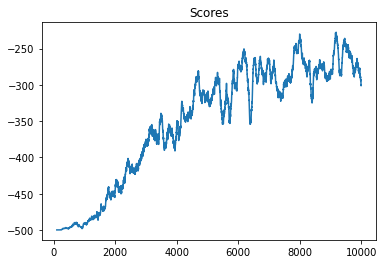

In [16]:
def plot_scores(scores, rolling_window=100):
    """Plot rolling mean using specified window."""
#     plt.plot(scores)
    plt.title("Scores");
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean);
    return rolling_mean

rolling_mean = plot_scores(scores)

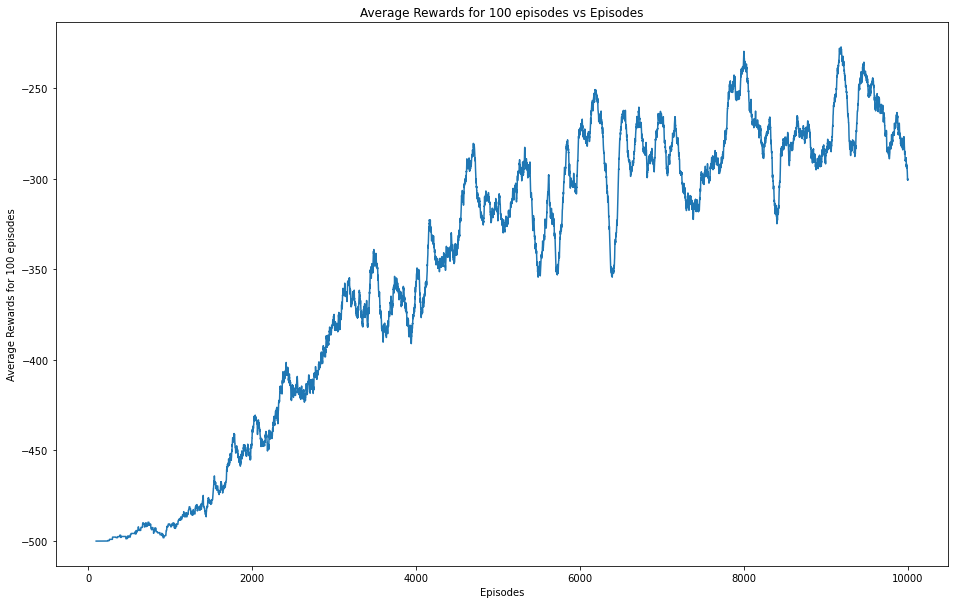

In [20]:
plt.figure(figsize=(16,10))
plt.plot(rolling_mean)
plt.title("Average Rewards for 100 episodes vs Episodes")
plt.xlabel("Episodes")
plt.ylabel("Average Rewards for 100 episodes")
plt.savefig("tc_sarsa_acro.jpeg")